# **Project Phase 2: Model Execution Instructions**

This directory contains the source code for the 6 machine learning and statistical models applied to the NYC Green Taxi dataset for the EAS 587 course project.

## **Requirements**

* A web browser  
* A Google Account (for using Google Colab)

## **Files Included**

* `taxi_data.csv`: The dataset used by all notebooks.  
* `model_1_LinearRegression.ipynb`: Notebook for the Linear Regression model.  
* `model_2_KNN.ipynb`: Notebook for K-Nearest Neighbors and K-Means models.  
* `model_3_DecisionTree.ipynb`: Notebook for the Decision Tree classification model.  
* `model_4_RandomForest.ipynb`: Notebook for the Random Forest regression model.  
* `model_5_DBSCAN.ipynb`: Notebook for the DBSCAN clustering model.  
* `model_6_ARIMA.ipynb`: Notebook for the ARIMA and Prophet time-series models.

## **Step-by-Step Execution Instructions**

To reproduce the results, please follow these steps for each of the 6 notebooks.

1. **Navigate to Google Colab** Open your web browser and go to [https://colab.research.google.com/](https://colab.research.google.com/).  
2. **Upload Project Files** On the left-hand side of the Colab interface, click the **"Files"** icon (it looks like a folder). Click the **"Upload to session storage"** icon and select all the files from this `src/` directory (the 6 `.ipynb` notebooks and `taxi_data.csv`). Wait for all files to finish uploading.  
3. **Open a Notebook** In the file browser on the left, double-click on one of the notebook files (e.g., `LinearRegression.ipynb`) to open it in the main editor.  
4. **Run the Notebook** Once the notebook is open and has connected to a runtime, go to the top menu and select **Runtime \-\> Run all**.  
5. **View Results** The notebook will now execute from the first cell to the last, producing all the model metrics, tables, and visualizations described in the report.  
6. **Repeat for Other Models** Repeat steps 3-5 for the remaining 5 notebook files to see the results for each model. Make sure you upload the `taxi_data.csv` file for every python notebook.

**Important Note on Colab Runtimes:** The files uploaded to a Google Colab session are temporary. If your session disconnects or times out (e.g., after being idle), the uploaded files will be deleted. If this happens, you will need to re-upload the `taxi_data.csv` file (Step 2).



✅ Data loaded successfully.
   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2     01-01-2023 00:26      01-01-2023 00:37                  N   
1         2     01-01-2023 00:51      01-01-2023 00:57                  N   
2         2     01-01-2023 00:35      01-01-2023 00:41                  N   
3         1     01-01-2023 00:13      01-01-2023 00:19                  N   
4         1     01-01-2023 00:33      01-01-2023 00:39                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0           166           143              1.0           2.58   
1         1.0            24            43              1.0           1.81   
2         1.0           223           179              1.0           0.00   
3         1.0            41           238              1.0           1.30   
4         1.0            41            74              1.0           1.10   

   fare_amount  extra  mta_tax  tip_amount  to

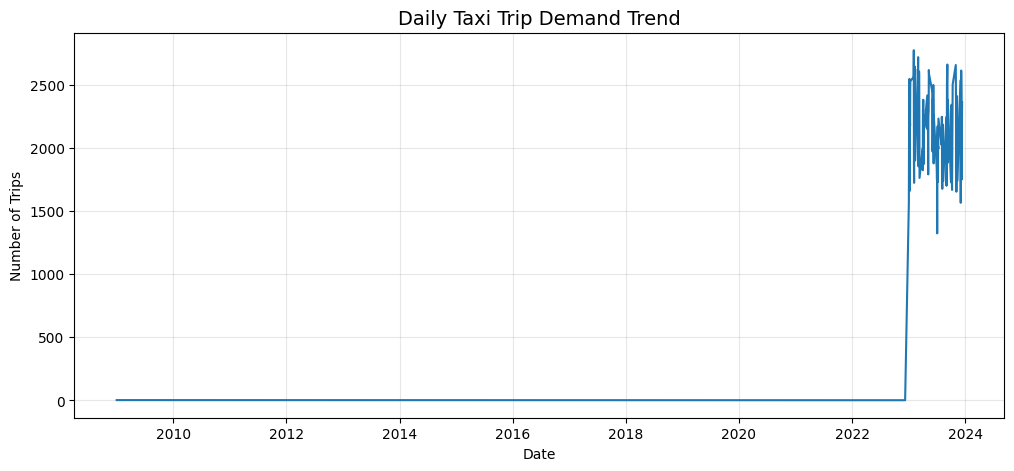


ARIMA MAE: 246.30, RMSE: 283.60


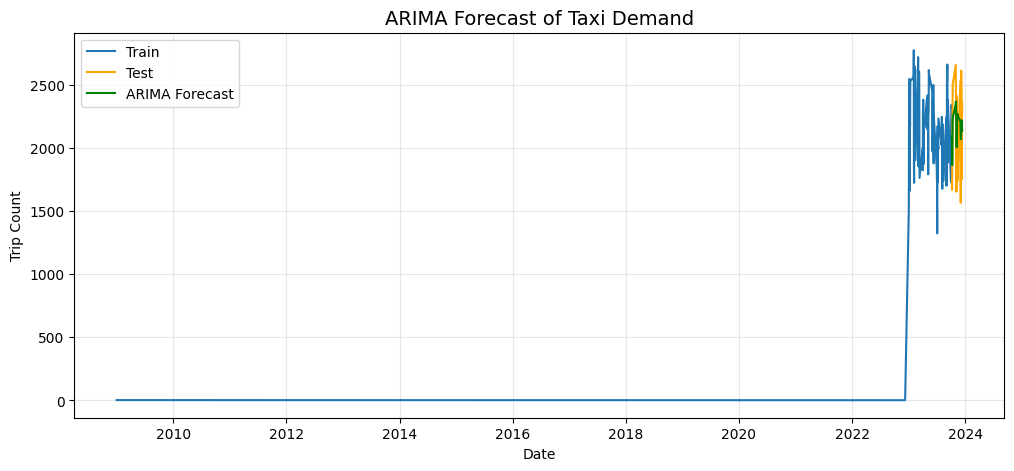

DEBUG:cmdstanpy:input tempfile: /tmp/tmpocfexlsh/wo8w0cvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpocfexlsh/2btry3rj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19232', 'data', 'file=/tmp/tmpocfexlsh/wo8w0cvp.json', 'init=/tmp/tmpocfexlsh/2btry3rj.json', 'output', 'file=/tmp/tmpocfexlsh/prophet_model3rr4hmmo/prophet_model-20251019230825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:08:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet MAE: 133.88, RMSE: 171.70


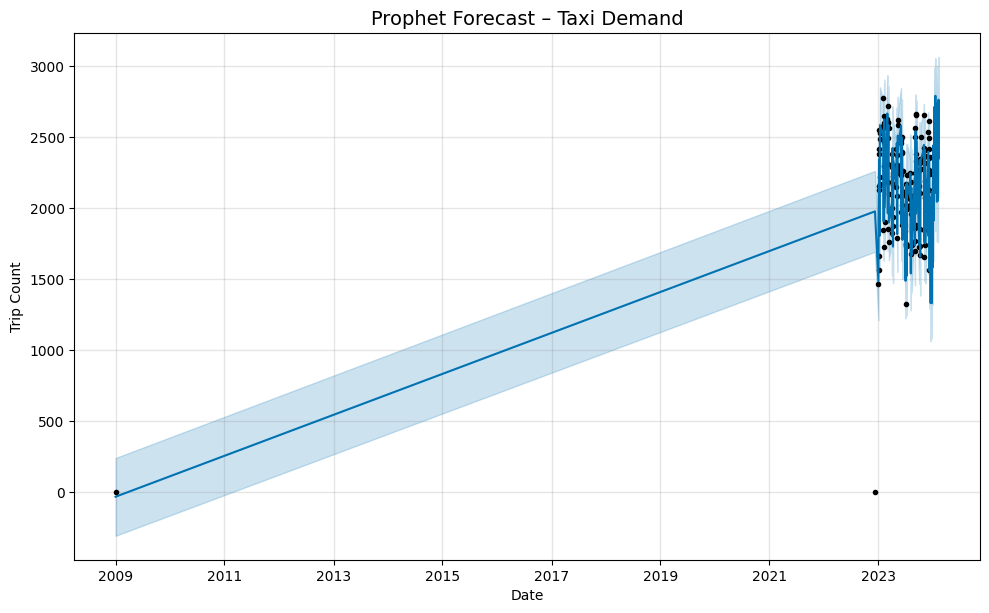

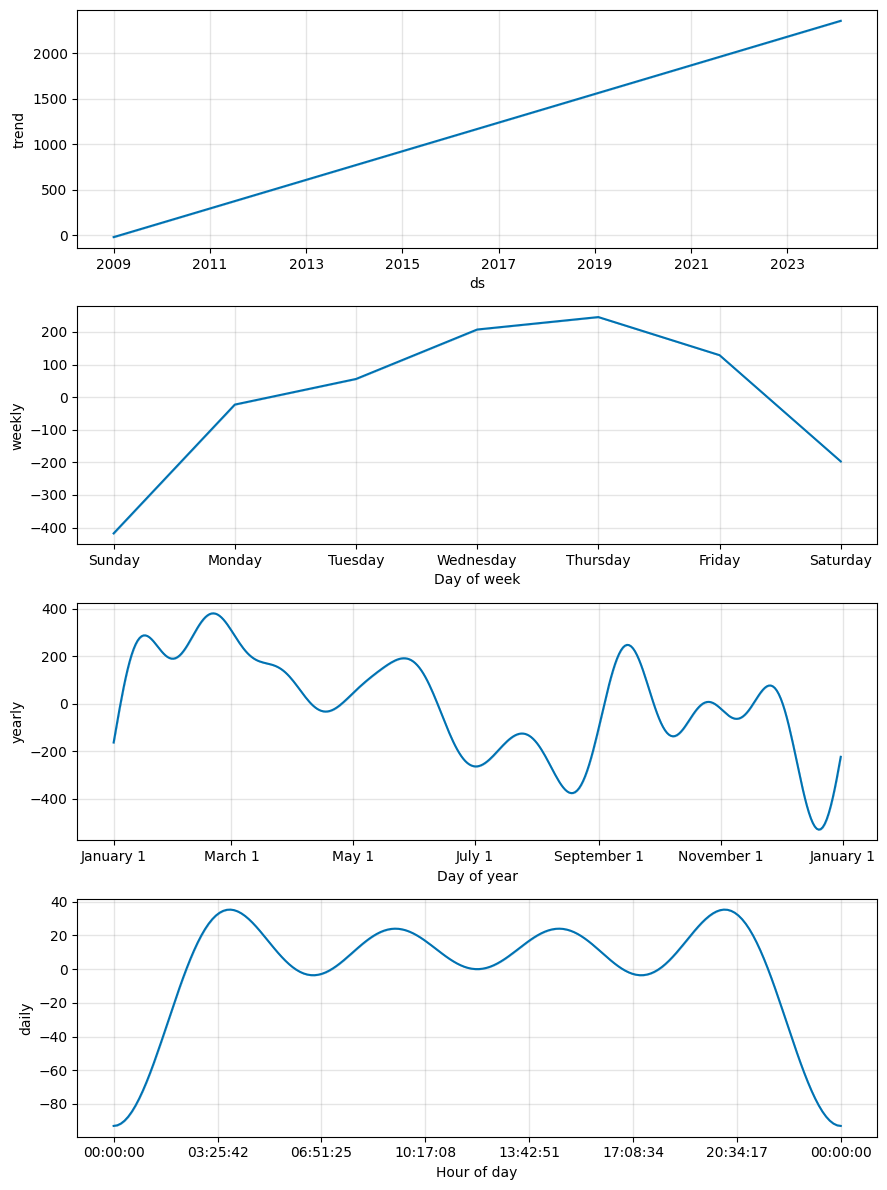

In [1]:
# ==========================================================
# STEP 1 — Import Libraries
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# ==========================================================
# STEP 2 — Load Dataset
# ==========================================================
df = pd.read_csv("taxi_data.csv", low_memory=False)
print("✅ Data loaded successfully.")
print(df.head())

# ==========================================================
# STEP 3 — Prepare Time Series Data
# ==========================================================
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')
df = df.dropna(subset=['lpep_pickup_datetime'])

# Create daily trip counts
df['date'] = df['lpep_pickup_datetime'].dt.date
daily_demand = df.groupby('date').size().reset_index(name='trip_count')

print(f"\n✅ Time series data prepared: {daily_demand.shape[0]} days of data")
print(daily_demand.head())

# ==========================================================
# STEP 4 — Visualize the daily demand trend
# ==========================================================
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='trip_count', data=daily_demand, linewidth=1.5)
plt.title("Daily Taxi Trip Demand Trend", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================================
# STEP 5 — Split data into training and testing sets
# ==========================================================
train = daily_demand.iloc[:-30]  # all but last 30 days
test = daily_demand.iloc[-30:]   # last 30 days for testing

# ==========================================================
# STEP 6 — Apply ARIMA model
# ==========================================================
# ARIMA requires a time-indexed series
train_series = pd.Series(train['trip_count'].values, index=pd.to_datetime(train['date']))

model = ARIMA(train_series, order=(2, 1, 2))  # can be tuned using AIC later
fitted_model = model.fit()

# Forecast next 30 days
forecast = fitted_model.forecast(steps=30)
forecast.index = pd.to_datetime(test['date'])

# Evaluate ARIMA performance
mae = mean_absolute_error(test['trip_count'], forecast)
rmse = np.sqrt(mean_squared_error(test['trip_count'], forecast))
print(f"\nARIMA MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot ARIMA results
plt.figure(figsize=(12, 5))
plt.plot(train['date'], train['trip_count'], label='Train')
plt.plot(test['date'], test['trip_count'], label='Test', color='orange')
plt.plot(test['date'], forecast, label='ARIMA Forecast', color='green')
plt.title("ARIMA Forecast of Taxi Demand", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================================
# STEP 7 — Apply Prophet model
# ==========================================================
prophet_df = daily_demand.rename(columns={'date': 'ds', 'trip_count': 'y'})

# Fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_df)

# Forecast next 60 days
future = prophet_model.make_future_dataframe(periods=60)
forecast_prophet = prophet_model.predict(future)

# Evaluate Prophet on the last 30 days
test_prophet = forecast_prophet.set_index('ds').loc[test['date']]
mae_p = mean_absolute_error(test['trip_count'], test_prophet['yhat'])
rmse_p = np.sqrt(mean_squared_error(test['trip_count'], test_prophet['yhat']))
print(f"\nProphet MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}")

# ==========================================================
# STEP 8 — Prophet Visualization
# ==========================================================
fig1 = prophet_model.plot(forecast_prophet, xlabel='Date', ylabel='Trip Count')
plt.title("Prophet Forecast – Taxi Demand", fontsize=14)
plt.show()

fig2 = prophet_model.plot_components(forecast_prophet)
plt.show()
